# Explainable AI (XAI)

- Los métodos de explicabilidad nos permiten obtener explicaciones para cada predicción puntual del modelo
### SHAP

- SHAP estima cuánto aporta cada variable (en este caso, cada instante de los 24 anteriores) a la predicción en un punto temporal determinado.
- De forma intuitiva, genera combinaciones de los datos de entrada para ver cuanto contribuye cada una de ellas a la predicción final

> Por ejemplo:  
> "La ocupación predicha es alta porque es lunes a las 8 AM, hubo alta ocupación en las últimas 2 horas, y hay un evento cercano.

#### SHAP vs Model Weights
-	Los pesos de la red indican de forma genérica cual es el peso de cada característica, mientras que los valores SHAP indican la importancia de cada característica para una predicción específica 

#### Beneficios para la interpretación

- Transparencia para presentar resultados
- Mejora la confianza en el modelo.


#### Limitaciones de SHAP
- El cálculo de valores SHAP es **computacionalmente costoso**, especialmente en modelos de **Deep Learning**.
- Su rendimiento y viabilidad dependen en gran medida del **hardware disponible** (especialmente la GPU).
- En este caso, al trabajar con una ventana temporal relativamente amplia (24 instantes), solo es posible utilizar unas **50 muestras** para el análisis, lo cual puede afectar la **fiabilidad y representatividad** de las interpretaciones obtenidas.

> Por tanto, los resultados SHAP deben interpretarse con cautela en este contexto, y complementar —no reemplazar— otras formas de análisis.


In [11]:
import sys
sys.path.append("../scripts")
from TorchDataset import TimeSeriesDataset
from Models import VanillaLSTM, VanillaRNN, VanillaGRU
from Saving_and_Paths import get_experiment_path

In [12]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import json
import shap
import matplotlib.pyplot as plt

In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 2
BATCH_SIZE = 64
HIDDEN_SIZE = 32
NUM_LAYERS = 1
DROPOUT_RATE = 0.0
LEARNING_RATE = 1e-3

OPTUNA_TRIALS = 2  # nº experimentos a probar con Optuna

VALIDATION_DIR = "../experiments/validation"

INPUT_SIZE = 1
OUTPUT_SIZE = 1
WINDOW_INPUT_LENGTH = 24
WINDOW_OUTPUT_LENGTH = 1

In [15]:
model_classes = {
    "lstm": VanillaLSTM,
    "gru": VanillaGRU,
    "rnn": VanillaRNN
}

Antes de calcular los valores SHAP, es necesario:

1. **Cargar los modelos entrenados** junto con sus pesos y parámetros (ya sean fijos o optimizados con Optuna).
2. **Cargar los datasets de entrenamiento y test**, que serán utilizados como referencias para generar explicaciones.

Para mantener una estructura clara y escalable, se utilizan **diccionarios** (`models`, `train_dataloaders`, `test_dataloaders`, etc.) que permiten acceder fácilmente a los objetos correspondientes a cada combinación de `parking`, `modelo` y `tipo`.


In [ ]:
models = {}

for pid in os.listdir(VALIDATION_DIR):
    if pid in ["parking_6", "parking_7"]:
        for arch_name in ["rnn", "lstm", "gru"]:
            model_class = model_classes[arch_name]
            for tipo in ["vanilla", "optuna"]:

                #cargar modelo 
                model_path = os.path.join(VALIDATION_DIR, pid, arch_name, tipo, "model.pt")
                if not os.path.exists(model_path):
                    print(f"⚠️ No se encontró el modelo en {model_path}. Saltando...\n")
                    continue

                #version optuna
                if tipo == "optuna":
                    best_params_path = os.path.join(VALIDATION_DIR, pid, arch_name, tipo, "best_params.json")
                    with open(best_params_path, "r") as f:
                        best_params = json.load(f)


                    model = model_class(
                        input_size=INPUT_SIZE,
                        hidden_size=best_params["hidden_size"],
                        output_size=OUTPUT_SIZE,
                        num_layers=best_params["num_layers"]
                    )
                
                #version vanill
                else:
                    model = model_class(
                        input_size=INPUT_SIZE,
                        hidden_size=HIDDEN_SIZE,
                        output_size=OUTPUT_SIZE,
                        num_layers=NUM_LAYERS
                    )
                model.load_state_dict(torch.load(model_path, map_location=DEVICE))
                model.to(DEVICE)
                
                # Guardar modelo con nombre identificativo
                model_name = f"{pid}_{arch_name}_{tipo}"
                models[model_name] = model

Cargar los datasets y generar dataloaders a partir de datasets

In [17]:
train_datasets = {}
test_datasets = {}

train_dataloaders = {}
test_dataloaders = {}

for pid in [6,7]:  # o usa glob si quieres automatizar
    dataset = torch.load(f"../data/pytorch_datasets/train/parking_{pid}.pt",
                         weights_only = False)
    
    train_datasets[pid] = dataset
    train_dataloaders[pid] = torch.utils.data.DataLoader(
        dataset,
        batch_size=128,
        shuffle=False
    )

for pid in [6,7]:  # o usa glob si quieres automatizar
    dataset = torch.load(f"../data/pytorch_datasets/train/parking_{pid}.pt",
                         weights_only = False)
    
    test_datasets[pid] = dataset
    test_dataloaders[pid] = torch.utils.data.DataLoader(
        dataset,
        batch_size=128,
        shuffle=False
    )



Calculamos los valores SHAP para todos los modelos de los dos primeros parkings (6 y 7).

PARKING  6
MODEL:  parking_6_rnn_vanilla


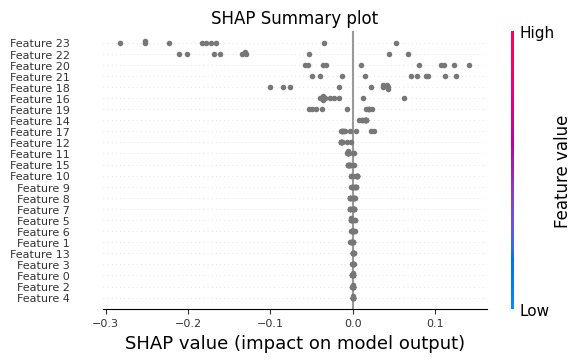

MODEL:  parking_6_rnn_optuna


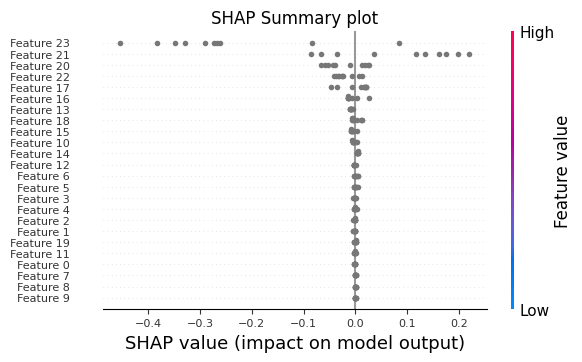

MODEL:  parking_6_lstm_vanilla


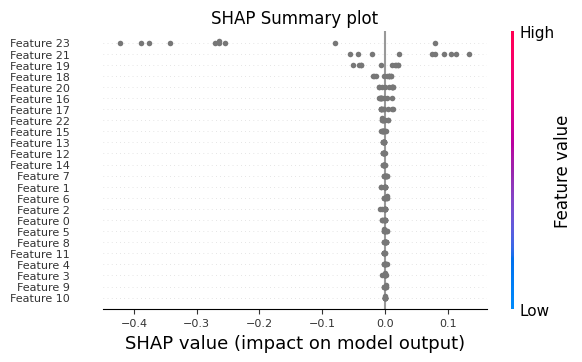

MODEL:  parking_6_lstm_optuna


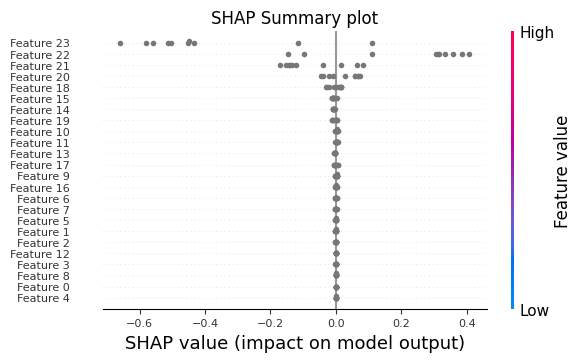

MODEL:  parking_6_gru_vanilla


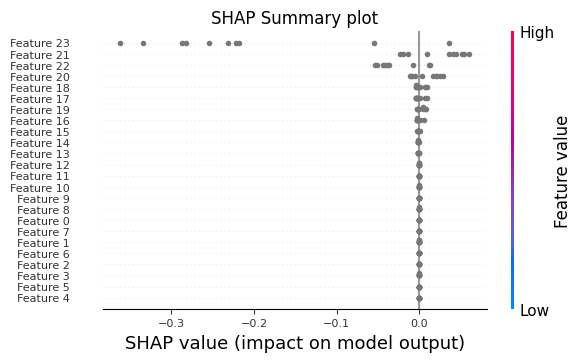

MODEL:  parking_6_gru_optuna


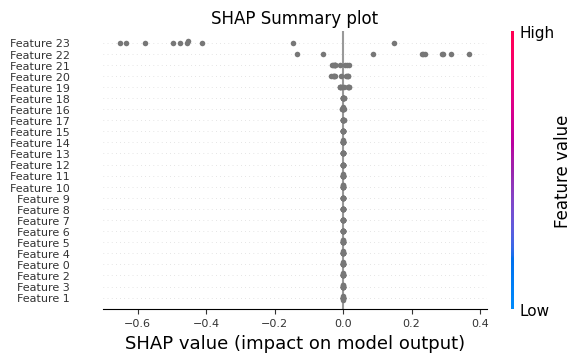

MODEL:  parking_7_rnn_vanilla


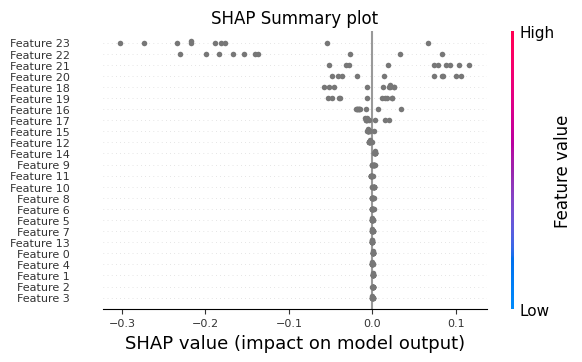

MODEL:  parking_7_rnn_optuna


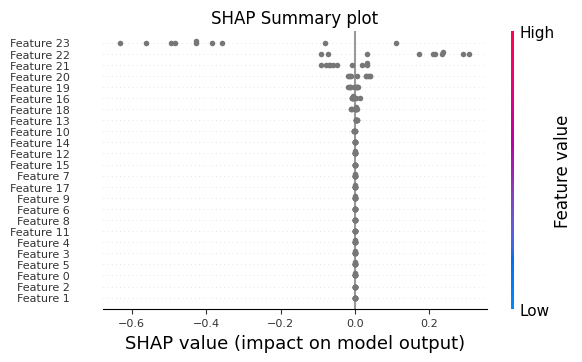

MODEL:  parking_7_lstm_vanilla


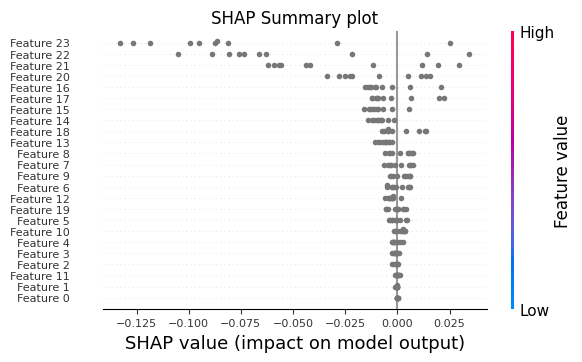

MODEL:  parking_7_lstm_optuna


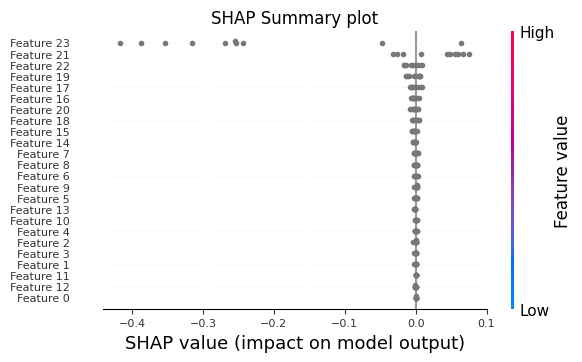

MODEL:  parking_7_gru_vanilla


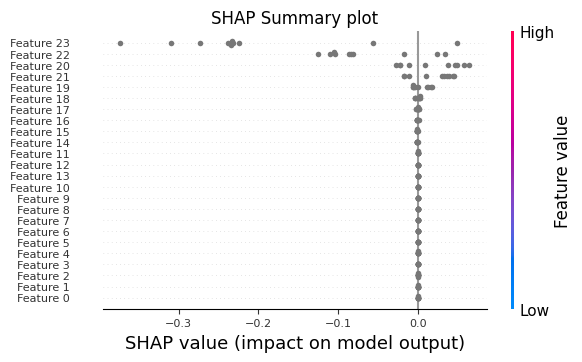

MODEL:  parking_7_gru_optuna


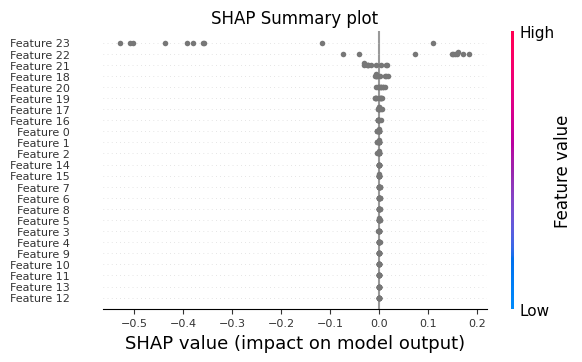

PARKING  7
MODEL:  parking_6_rnn_vanilla


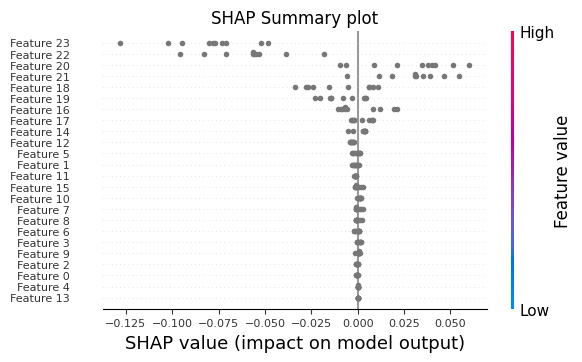

MODEL:  parking_6_rnn_optuna


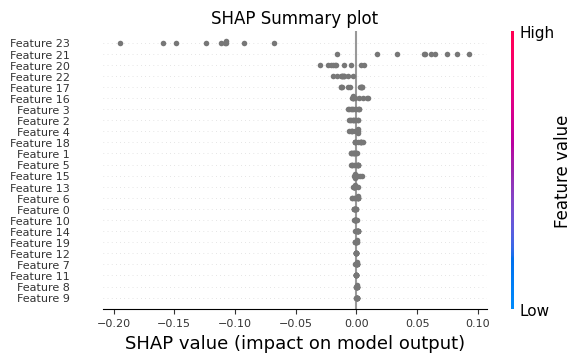

MODEL:  parking_6_lstm_vanilla


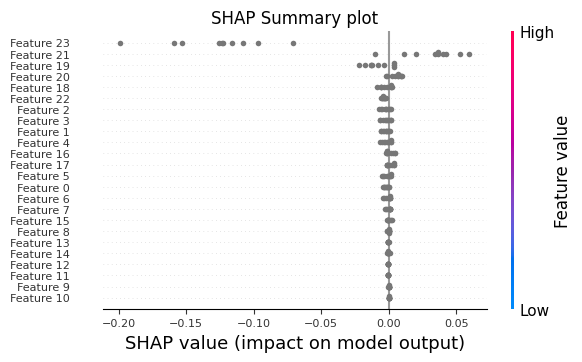

MODEL:  parking_6_lstm_optuna


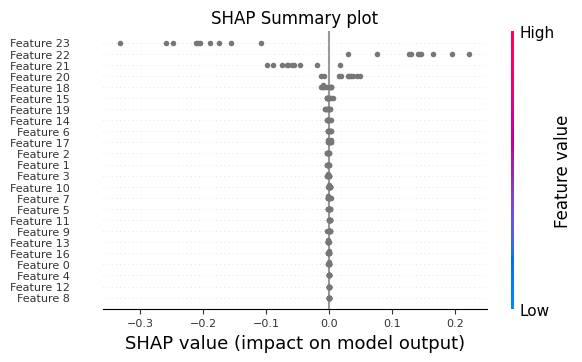

MODEL:  parking_6_gru_vanilla


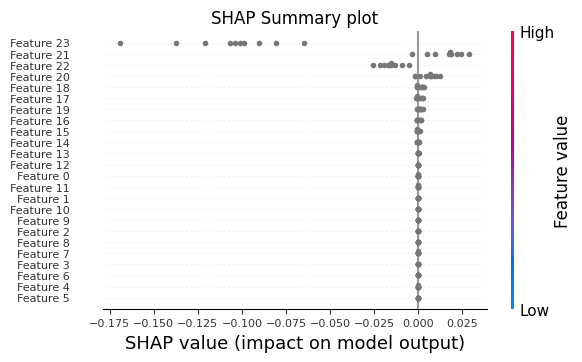

MODEL:  parking_6_gru_optuna


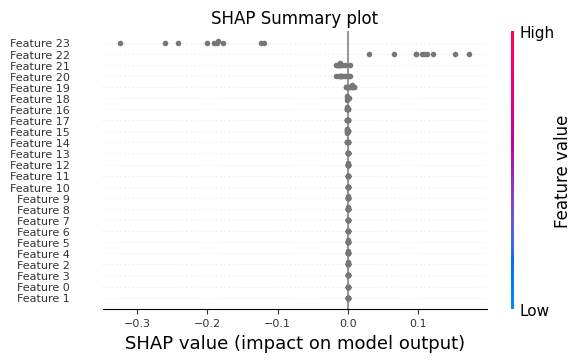

MODEL:  parking_7_rnn_vanilla


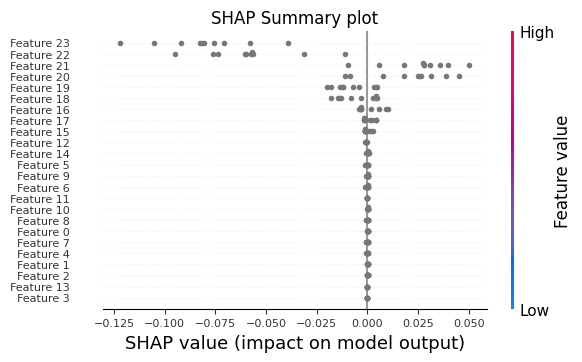

MODEL:  parking_7_rnn_optuna


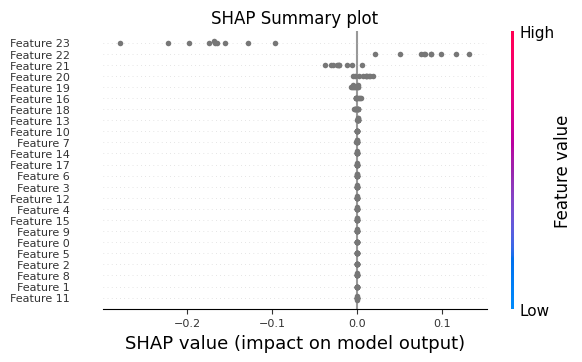

MODEL:  parking_7_lstm_vanilla


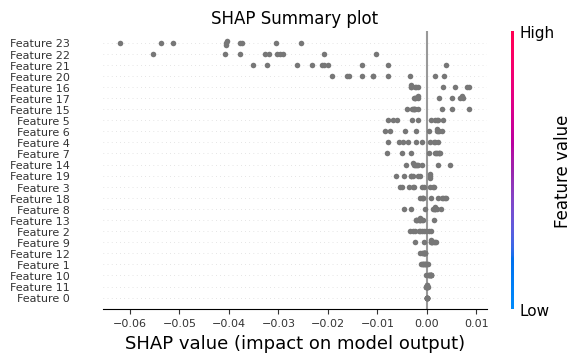

MODEL:  parking_7_lstm_optuna


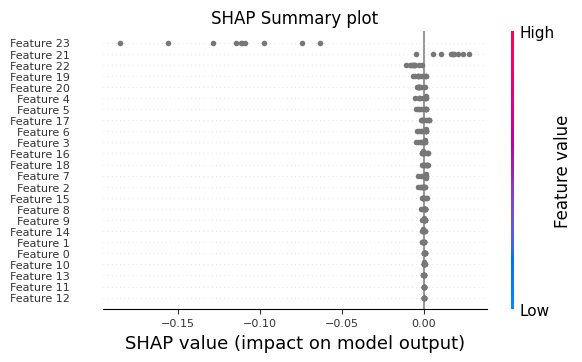

MODEL:  parking_7_gru_vanilla


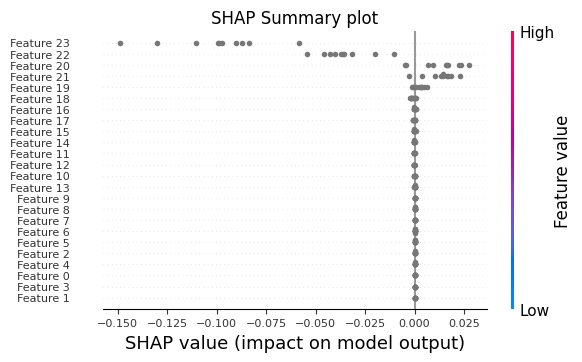

MODEL:  parking_7_gru_optuna


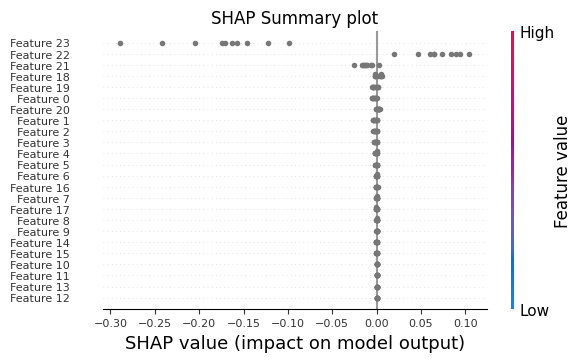

In [28]:
# import tensorflow
for pid in list(train_dataloaders.keys())[:2]:
        print("PARKING ", pid)
        for model_key, model in models.items():
                print("MODEL: ", model_key)
                #model = model.to(DEVICE)
                # Obtener un batch del dataloader
                X_batch_train, _ = next(iter(train_dataloaders[pid]))
                X_batch_train = X_batch_train.to(DEVICE)

                # Obtener un batch del dataloader
                X_batch_test, _ = next(iter(test_dataloaders[pid]))
                X_batch_test = X_batch_test.to(DEVICE)

                explainer = shap.GradientExplainer(model, X_batch_train[:40])
                model.train()
                shap_values = explainer.shap_values(X_batch_test[:10])


                rng = np.random.default_rng(785412)
                shap.summary_plot(shap_values.squeeze(), X_batch_test[:10], max_display=24, show=False, rng = rng)
                fig, ax = plt.gcf(), plt.gca()
                ax.set_title("SHAP Summary plot")
                ax.tick_params(labelsize=8)
                fig.set_size_inches(6, 3)
                plt.show()

Como se puede observar, los observaciones inmediatamente anteriores son siempre las más influyentes en el resultado, a pesar de que al calcular la estacionalidad casi siempre había una componente cíclica de 24 horas en todos los parkings. Una alternativa sería reducir el tamaño de la ventana y comparar la calidad de los resultados.